# Ch5. RNN, 순환 신경망

In [1]:
import sys
sys.path.append('D:/ANACONDA/envs/tf-gpu/code/NLP')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
#from simple_rnnlm import SimpleRnnlm

In [31]:
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D)/100).astype('f')
        rnn_Wx = (rn(D,H)/np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H,H)/np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful = True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs,ts)
        return loss
    
    def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()
        

In [4]:
# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

In [24]:
# 학습 데이터 읽기(전체 중 천 개만)

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[corpus_size:corpus_size*2]
vocab_size = int(max(corpus) + 1)

In [25]:
for x in corpus[:50]:
    print(id_to_word[x], end=' ')

latest week to $ N billion <eos> typically money-fund yields beat comparable short-term investments because portfolio managers can vary maturities and go after the highest rates <eos> the top money funds are currently yielding well over N N <eos> dreyfus world-wide dollar the <unk> fund had a seven-day compound yield 

In [26]:
xs = corpus[:-1] # shape : (999,)
ts = corpus[1:] # shape : (999,) 
data_size = len(xs)
print('말뭉치 크기: %d, 어휘수 %d'%(corpus_size,vocab_size))

말뭉치 크기: 1000, 어휘수 718


In [29]:
# 학습 시 사용하는 변수
max_ites = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

In [32]:
# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

In [39]:
# 각 미니배치에서 샘플의 시작 위치를 계산
jump = (corpus_size -1) // batch_size
offsets = [i * jump for i in range(batch_size)] # [0, 99, 198, 297, 396, 495, 594, 693, 792, 891]

for epoch in range(max_epoch):
    for iter in range(max_ites):
        # 미니배치 획득
        batch_x = np.empty((batch_size, time_size), dtype = 'i')
        batch_t = np.empty((batch_size, time_size), dtype = 'i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i,t] = xs[(offset+time_idx) % data_size]
                batch_t[i,t] = ts[(offset+time_idx) % data_size]
            time_idx += 1
        # shuffle 필요할 것 같음
        
        # 기울기 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # epoch 마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    if(epoch % 10 == 0) :
        print('| epoch %d | 퍼플렉서티 %.2f'%(epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0,0

| epoch 1 | 퍼플렉서티 605.98
| epoch 11 | 퍼플렉서티 200.51
| epoch 21 | 퍼플렉서티 185.40
| epoch 31 | 퍼플렉서티 173.22
| epoch 41 | 퍼플렉서티 159.60
| epoch 51 | 퍼플렉서티 139.62
| epoch 61 | 퍼플렉서티 110.46
| epoch 71 | 퍼플렉서티 80.00
| epoch 81 | 퍼플렉서티 53.91
| epoch 91 | 퍼플렉서티 33.24


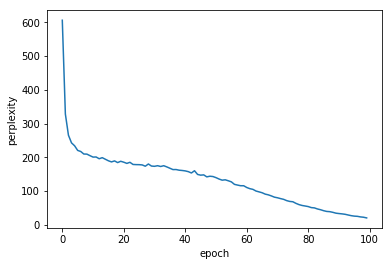

In [43]:
ylim = None
x = np.arange(len(ppl_list))
if ylim is not None:
    plt.ylim(*ylim)
plt.plot(x,ppl_list, label='train')
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.show()

In [61]:
import numpy
import time
from common.util import clip_grads

class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 퍼플렉서티 평가
            if (eval_interval is not None) and (iters % eval_interval) == 0:
                ppl = np.exp(total_loss / loss_count)
                elapsed_time = time.time() - start_time
                    
                self.ppl_list.append(float(ppl))
                total_loss, loss_count = 0, 0
            if(epoch % 10 == 0):
                print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('epoch (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()


def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [62]:
model = SimpleRnnlm(vocab_size,wordvec_size,hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model,optimizer)

In [63]:
trainer.fit(xs,ts,max_epoch,batch_size,time_size,eval_interval = 1)

| 에폭 1 |  반복 19 / 19 | 시간 0[s] | 퍼플렉서티 646.75
| 에폭 11 |  반복 19 / 19 | 시간 0[s] | 퍼플렉서티 201.63
| 에폭 21 |  반복 19 / 19 | 시간 1[s] | 퍼플렉서티 186.96
| 에폭 31 |  반복 19 / 19 | 시간 1[s] | 퍼플렉서티 175.04
| 에폭 41 |  반복 19 / 19 | 시간 2[s] | 퍼플렉서티 160.17
| 에폭 51 |  반복 19 / 19 | 시간 3[s] | 퍼플렉서티 133.87
| 에폭 61 |  반복 19 / 19 | 시간 3[s] | 퍼플렉서티 102.36
| 에폭 71 |  반복 19 / 19 | 시간 4[s] | 퍼플렉서티 69.65
| 에폭 81 |  반복 19 / 19 | 시간 4[s] | 퍼플렉서티 45.94
| 에폭 91 |  반복 19 / 19 | 시간 5[s] | 퍼플렉서티 27.48


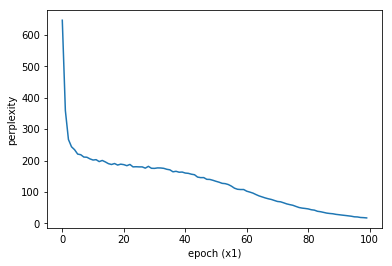

In [64]:
trainer.plot()

# 정리

- RNN, 순환 신경망을 살펴봄
- 긴 시계열 데이터 학습시 데이터를 적당한 길이(time_size)씩 잘라 backpropagation을 수행 = Truncated BPTT
- forward의 경우 순차적으로 입력해야하므로 연결을 끊으면 안됨
- 언어 모델은 단어 시퀀스를 확률로 해석

# 추가로 더 볼 사항

- RnnlmTrainer 에서 remove duplicate 부분 +
- batch 에서 shuffle 추가 +
- TimeEmb -> TimeRnn -> TimeAffine 까지 도식화 +